In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import os
from PIL import Image
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

## Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# CustomImageDataset 클래스 정의
class CustomImageDataset(Dataset):  # 'Dataset'을 상속받습니다.
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 데이터셋 로드
trainB_dataset = CustomImageDataset('/content/drive/MyDrive/KUBIC-CV/StyleChangeModel/datasets/data_korean_resized', transform=transform)
trainA_dataset = CustomImageDataset('/content/drive/MyDrive/KUBIC-CV/StyleChangeModel/datasets/data_monet', transform=transform)

# DataLoader 생성
loader_A = DataLoader(trainA_dataset, batch_size=1, shuffle=True)
loader_B = DataLoader(trainB_dataset, batch_size=1, shuffle=True)


## Style Extractor


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class VGG19Extractor(nn.Module):
    def __init__(self, style_layers=None, content_layers=None):
        super(VGG19Extractor, self).__init__()

        # VGG19 모델 로드 및 features 추출
        vgg19 = models.vgg19(pretrained=True).features

        # 기본 레이어 설정
        default_style_layers = ['slice1', 'slice2', 'slice3', 'slice4', 'slice5']
        default_content_layers = ['slice4']

        # 사용자 지정 레이어가 없을 경우 기본 레이어 사용
        self.style_layers = style_layers if style_layers else default_style_layers
        self.content_layers = content_layers if content_layers else default_content_layers

        # 레이어 슬라이스
        self.slice1 = nn.Sequential(*[vgg19[i] for i in range(2)])
        self.slice2 = nn.Sequential(*[vgg19[i] for i in range(2, 7)])
        self.slice3 = nn.Sequential(*[vgg19[i] for i in range(7, 12)])
        self.slice4 = nn.Sequential(*[vgg19[i] for i in range(12, 21)])
        self.slice5 = nn.Sequential(*[vgg19[i] for i in range(21, 30)])

        # 모든 파라미터 고정 (학습하지 않음)
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = {}
        h = x

        if 'slice1' in self.style_layers + self.content_layers:
            h = self.slice1(h)
            features['slice1'] = h
        if 'slice2' in self.style_layers + self.content_layers:
            h = self.slice2(h)
            features['slice2'] = h
        if 'slice3' in self.style_layers + self.content_layers:
            h = self.slice3(h)
            features['slice3'] = h
        if 'slice4' in self.style_layers + self.content_layers:
            h = self.slice4(h)
            features['slice4'] = h
        if 'slice5' in self.style_layers + self.content_layers:
            h = self.slice5(h)
            features['slice5'] = h

        # 스타일과 콘텐츠 피처 분리
        style_features = {layer: features[layer] for layer in self.style_layers if layer in features}
        content_features = {layer: features[layer] for layer in self.content_layers if layer in features}

        return {'style': style_features, 'content': content_features}

# Gram Matrix 함수 (스타일 추출에 필요)
def gram_matrix(input_tensor):
    b, c, h, w = input_tensor.size()
    features = input_tensor.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G.div(h * w)


## Style Extractor


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class VGG19Extractor(nn.Module):
    def __init__(self, style_layers=None, content_layers=None):
        super(VGG19Extractor, self).__init__()

        # VGG19 모델 로드 및 features 추출
        vgg19 = models.vgg19(pretrained=True).features

        # 기본 레이어 설정
        default_style_layers = ['slice1', 'slice2', 'slice3', 'slice4', 'slice5']
        default_content_layers = ['slice4']

        # 사용자 지정 레이어가 없을 경우 기본 레이어 사용
        self.style_layers = style_layers if style_layers else default_style_layers
        self.content_layers = content_layers if content_layers else default_content_layers

        # 레이어 슬라이스
        self.slice1 = nn.Sequential(*[vgg19[i] for i in range(2)])
        self.slice2 = nn.Sequential(*[vgg19[i] for i in range(2, 7)])
        self.slice3 = nn.Sequential(*[vgg19[i] for i in range(7, 12)])
        self.slice4 = nn.Sequential(*[vgg19[i] for i in range(12, 21)])
        self.slice5 = nn.Sequential(*[vgg19[i] for i in range(21, 30)])

        # 모든 파라미터 고정 (학습하지 않음)
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = {}
        h = x

        if 'slice1' in self.style_layers + self.content_layers:
            h = self.slice1(h)
            features['slice1'] = h
        if 'slice2' in self.style_layers + self.content_layers:
            h = self.slice2(h)
            features['slice2'] = h
        if 'slice3' in self.style_layers + self.content_layers:
            h = self.slice3(h)
            features['slice3'] = h
        if 'slice4' in self.style_layers + self.content_layers:
            h = self.slice4(h)
            features['slice4'] = h
        if 'slice5' in self.style_layers + self.content_layers:
            h = self.slice5(h)
            features['slice5'] = h

        # 스타일과 콘텐츠 피처 분리
        style_features = {layer: features[layer] for layer in self.style_layers if layer in features}
        content_features = {layer: features[layer] for layer in self.content_layers if layer in features}

        return {'style': style_features, 'content': content_features}

# Gram Matrix 함수 (스타일 추출에 필요)
def gram_matrix(input_tensor):
    b, c, h, w = input_tensor.size()
    features = input_tensor.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G.div(h * w)


## Generator

In [ ]:
# ResNet 기반의 제너레이터
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=9):
        super(Generator, self).__init__()
        # 입력 레이어
        model = [nn.Conv2d(input_nc, 64, kernel_size=7, padding=3),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(True)]

        # 다운샘플링 레이어
        for i in range(2):
            mult = 2 ** i
            model += [nn.Conv2d(64 * mult, 64 * mult * 2, kernel_size=3, stride=2, padding=1),
                      nn.InstanceNorm2d(64 * mult * 2),
                      nn.ReLU(True)]

        # ResNet 블록
        mult = 2 ** 2
        for i in range(n_blocks):
            model += [ResnetBlock(64 * mult)]

        # 업샘플링 레이어
        for i in range(2):
            mult = 2 ** (2 - i)
            model += [nn.ConvTranspose2d(64 * mult, int(64 * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1),
                      nn.InstanceNorm2d(int(64 * mult / 2)),
                      nn.ReLU(True)]

        # 출력 레이어
        model += [nn.Conv2d(64, output_nc, kernel_size=7, padding=3)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# ResNet Block 정의
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                       nn.InstanceNorm2d(dim)]
        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

## Discrimminator

In [ ]:
class Discrimminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(Discrimminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)


## loss fuction and etc.

In [ ]:
# 손실 함수 정의
criterion_GAN = nn.MSELoss()  # GAN 손실
criterion_cycle = nn.L1Loss()  # 사이클 일관성 손실
criterion_identity = nn.L1Loss()  # 정체성 손실

# 예시로 사용할 손실 함수 래퍼
def gan_loss(pred, target_is_real):
    target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
    return criterion_GAN(pred, target)

def cycle_consistency_loss(real, rec):
    return criterion_cycle(real, rec)

def identity_loss(real, same):
    return criterion_identity(real, same)

## Training

In [ ]:
import os
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils

# 디바이스 설정 (GPU가 있으면 사용하고, 없으면 CPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 하이퍼파라미터 설정
num_epochs = 300
input_nc = 3  # 입력 채널 수 (RGB 이미지이므로 3)
output_nc = 3  # 출력 채널 수 (목표 이미지도 RGB이므로 3)

# 모델 초기화
G_A2B = Generator(input_nc, output_nc).to(device)
G_B2A = Generator(input_nc, output_nc).to(device)
D_A = Discrimminator(input_nc).to(device)
D_B = Discrimminator(input_nc).to(device)

vgg = VGG19Extractor(style_layers=['slice1', 'slice2', 'slice3'], content_layers=['slice4']).to(device)

# 옵티마이저 정의
optimizer_G = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 손실 함수 정의
criterion_GAN = nn.MSELoss()  # GAN 손실
criterion_cycle = nn.L1Loss()  # 사이클 일관성 손실
criterion_identity = nn.L1Loss()  # 아이덴티티 손실



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.3MB/s]


In [ ]:
for epoch in range(num_epochs):
    for i, (data_A, data_B) in enumerate(zip(loader_A, loader_B)):
        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)

        # 제너레이터 업데이트
        optimizer_G.zero_grad()

        # A -> B, B -> A 변환 및 재구성
        fake_B = G_A2B(real_A)
        rec_A = G_B2A(fake_B)

        fake_A = G_B2A(real_B)
        rec_B = G_A2B(fake_A)

        # GAN 손실
        loss_G_A2B = gan_loss(D_B(fake_B), True)
        loss_G_B2A = gan_loss(D_A(fake_A), True)

        # 사이클 일관성 손실
        loss_cycle_A = cycle_consistency_loss(real_A, rec_A)
        loss_cycle_B = cycle_consistency_loss(real_B, rec_B)

        # 정체성 손실
        loss_identity_A = identity_loss(real_A, G_B2A(real_A))
        loss_identity_B = identity_loss(real_B, G_A2B(real_B))

        # 총 제너레이터 손실
        loss_G = loss_G_A2B + loss_G_B2A + 10 * (loss_cycle_A + loss_cycle_B) + 5 * (loss_identity_A + loss_identity_B)
        loss_G.backward()
        optimizer_G.step()

        # 디스크리미네이터 A 업데이트
        optimizer_D_A.zero_grad()
        loss_D_A = (gan_loss(D_A(real_A), True) + gan_loss(D_A(fake_A.detach()), False)) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # 디스크리미네이터 B 업데이트
        optimizer_D_B.zero_grad()
        loss_D_B = (gan_loss(D_B(real_B), True) + gan_loss(D_B(fake_B.detach()), False)) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # 로그 출력 (100 배치마다)
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{min(len(loader_A), len(loader_B))}")


print("Training finished.")

Epoch [0/300] Batch 0/68
Epoch [1/300] Batch 0/68
Epoch [2/300] Batch 0/68
Epoch [3/300] Batch 0/68
Epoch [4/300] Batch 0/68
Epoch [5/300] Batch 0/68
Epoch [6/300] Batch 0/68
Epoch [7/300] Batch 0/68
Epoch [8/300] Batch 0/68
Epoch [9/300] Batch 0/68
Epoch [10/300] Batch 0/68
Epoch [11/300] Batch 0/68
Epoch [12/300] Batch 0/68
Epoch [13/300] Batch 0/68
Epoch [14/300] Batch 0/68
Epoch [15/300] Batch 0/68
Epoch [16/300] Batch 0/68
Epoch [17/300] Batch 0/68
Epoch [18/300] Batch 0/68
Epoch [19/300] Batch 0/68
Epoch [20/300] Batch 0/68
Epoch [21/300] Batch 0/68
Epoch [22/300] Batch 0/68
Epoch [23/300] Batch 0/68
Epoch [24/300] Batch 0/68
Epoch [25/300] Batch 0/68
Epoch [26/300] Batch 0/68
Epoch [27/300] Batch 0/68
Epoch [28/300] Batch 0/68
Epoch [29/300] Batch 0/68
Epoch [30/300] Batch 0/68
Epoch [31/300] Batch 0/68
Epoch [32/300] Batch 0/68
Epoch [33/300] Batch 0/68
Epoch [34/300] Batch 0/68
Epoch [35/300] Batch 0/68
Epoch [36/300] Batch 0/68
Epoch [37/300] Batch 0/68
Epoch [38/300] Batch 0

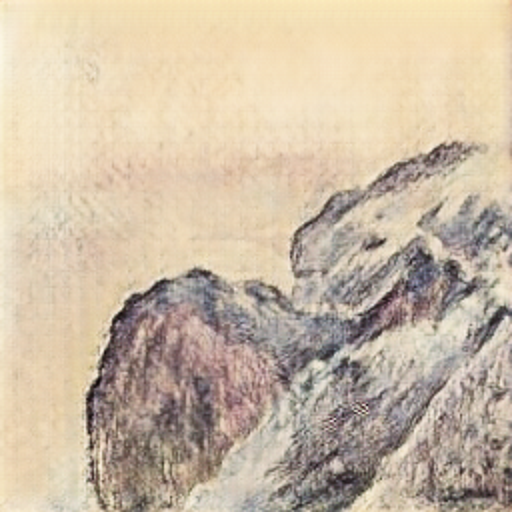

In [ ]:
from PIL import Image
from torchvision import transforms

# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 이미지를 로드하고 전처리
img = Image.open('/content/drive/MyDrive/KUBIC-CV/StyleChangeModel/datasets/data_monet/000c1e3bff.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# 이미지 변환 (한국 동양화를 서양화로 변환하는 예)
with torch.no_grad():
    output_tensor = G_A2B(img_tensor)

# 이미지 후처리
output_tensor = output_tensor.squeeze().cpu().detach()
output_tensor = (output_tensor + 1) / 2  # [-1, 1] 범위를 [0, 1]로 변환
output_img = transforms.ToPILImage()(output_tensor)

# 이미지 업스케일링 (예: 512x512)
upscale_size = (512, 512)  # 원하는 업스케일링 크기
output_img = output_img.resize(upscale_size, Image.BICUBIC)

# 결과 이미지 저장
output_img


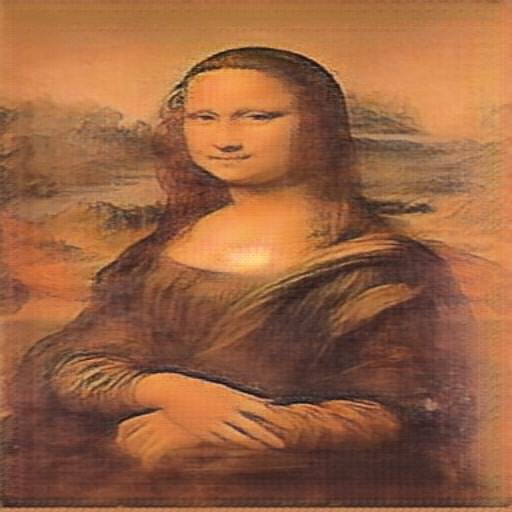

In [ ]:
from PIL import Image
from torchvision import transforms

# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 이미지를 로드하고 전처리
img = Image.open('/content/drive/MyDrive/KUBIC-CV/StyleChangeModel/datasets/data_classic_portrait/Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# 이미지 변환 (한국 동양화를 서양화로 변환하는 예)
with torch.no_grad():
    output_tensor = G_A2B(img_tensor)

# 이미지 후처리
output_tensor = output_tensor.squeeze().cpu().detach()
output_tensor = (output_tensor + 1) / 2  # [-1, 1] 범위를 [0, 1]로 변환
output_img = transforms.ToPILImage()(output_tensor)

# 이미지 업스케일링 (예: 512x512)
upscale_size = (512, 512)  # 원하는 업스케일링 크기
output_img = output_img.resize(upscale_size, Image.BICUBIC)

# 결과 이미지 저장
output_img


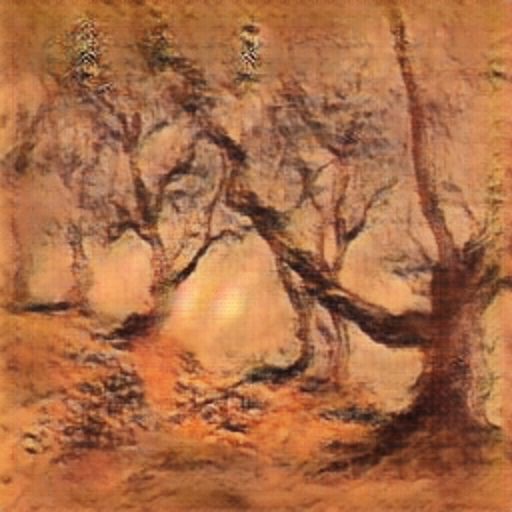

In [ ]:
from PIL import Image
from torchvision import transforms

# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 이미지를 로드하고 전처리
img = Image.open('/content/drive/MyDrive/KUBIC-CV/StyleChangeModel/datasets/data_monet_resized/011835cfbf.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# 이미지 변환 (한국 동양화를 서양화로 변환하는 예)
with torch.no_grad():
    output_tensor = G_A2B(img_tensor)

# 이미지 후처리
output_tensor = output_tensor.squeeze().cpu().detach()
output_tensor = (output_tensor + 1) / 2  # [-1, 1] 범위를 [0, 1]로 변환
output_img = transforms.ToPILImage()(output_tensor)

# 이미지 업스케일링 (예: 512x512)
upscale_size = (512, 512)  # 원하는 업스케일링 크기
output_img = output_img.resize(upscale_size, Image.BICUBIC)

# 결과 이미지 저장
output_img


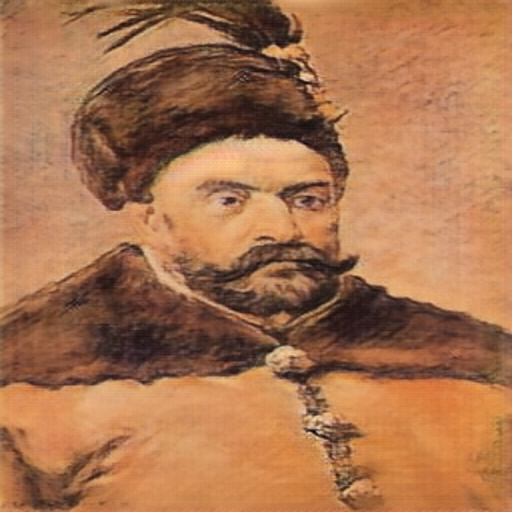

In [ ]:
from PIL import Image
from torchvision import transforms

# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 이미지를 로드하고 전처리
img = Image.open('/content/drive/MyDrive/KUBIC-CV/StyleChangeModel/datasets/data_classic_portrait/00afb8e719aa2ea716a5b6a54c5c55fbc.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# 이미지 변환 (한국 동양화를 서양화로 변환하는 예)
with torch.no_grad():
    output_tensor = G_A2B(img_tensor)

# 이미지 후처리
output_tensor = output_tensor.squeeze().cpu().detach()
output_tensor = (output_tensor + 1) / 2  # [-1, 1] 범위를 [0, 1]로 변환
output_img = transforms.ToPILImage()(output_tensor)

# 이미지 업스케일링 (예: 512x512)
upscale_size = (512, 512)  # 원하는 업스케일링 크기
output_img = output_img.resize(upscale_size, Image.BICUBIC)

# 결과 이미지 저장
output_img


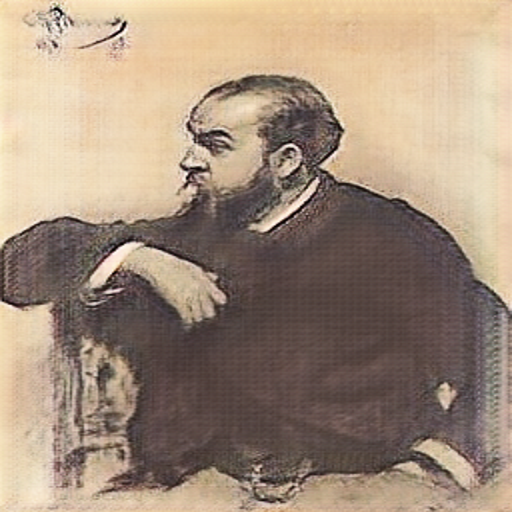

In [ ]:
from PIL import Image
from torchvision import transforms

# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 이미지를 로드하고 전처리
img = Image.open('/content/drive/MyDrive/KUBIC-CV/StyleChangeModel/datasets/data_classic_portrait/00c775299a9b11d6a4d310a1464d7493c.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# 이미지 변환 (한국 동양화를 서양화로 변환하는 예)
with torch.no_grad():
    output_tensor = G_A2B(img_tensor)

# 이미지 후처리
output_tensor = output_tensor.squeeze().cpu().detach()
output_tensor = (output_tensor + 1) / 2  # [-1, 1] 범위를 [0, 1]로 변환
output_img = transforms.ToPILImage()(output_tensor)

# 이미지 업스케일링 (예: 512x512)
upscale_size = (512, 512)  # 원하는 업스케일링 크기
output_img = output_img.resize(upscale_size, Image.BICUBIC)

# 결과 이미지 저장
output_img


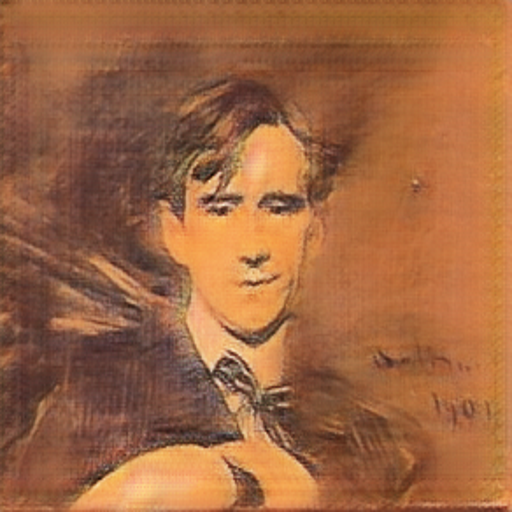

In [ ]:
from PIL import Image
from torchvision import transforms

# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 이미지를 로드하고 전처리
img = Image.open('/content/drive/MyDrive/KUBIC-CV/StyleChangeModel/datasets/data_classic_portrait/00e24bd88ccabec5dcecfbe97a9d14a7c.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# 이미지 변환 (한국 동양화를 서양화로 변환하는 예)
with torch.no_grad():
    output_tensor = G_A2B(img_tensor)

# 이미지 후처리
output_tensor = output_tensor.squeeze().cpu().detach()
output_tensor = (output_tensor + 1) / 2  # [-1, 1] 범위를 [0, 1]로 변환
output_img = transforms.ToPILImage()(output_tensor)

# 이미지 업스케일링 (예: 512x512)
upscale_size = (512, 512)  # 원하는 업스케일링 크기
output_img = output_img.resize(upscale_size, Image.BICUBIC)

# 결과 이미지 저장
output_img


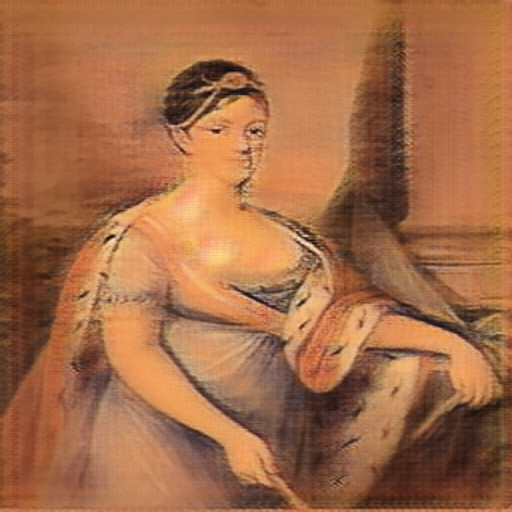

In [ ]:
from PIL import Image
from torchvision import transforms

# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 이미지를 로드하고 전처리
img = Image.open('/content/drive/MyDrive/KUBIC-CV/StyleChangeModel/datasets/data_classic_portrait/0453a25c0a8b7678b396ec1aa6bbea75c.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# 이미지 변환 (한국 동양화를 서양화로 변환하는 예)
with torch.no_grad():
    output_tensor = G_A2B(img_tensor)

# 이미지 후처리
output_tensor = output_tensor.squeeze().cpu().detach()
output_tensor = (output_tensor + 1) / 2  # [-1, 1] 범위를 [0, 1]로 변환
output_img = transforms.ToPILImage()(output_tensor)

# 이미지 업스케일링 (예: 512x512)
upscale_size = (512, 512)  # 원하는 업스케일링 크기
output_img = output_img.resize(upscale_size, Image.BICUBIC)

# 결과 이미지 저장
output_img
